<a href="https://colab.research.google.com/github/veroorli/ProjetProg/blob/master/TME1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUJET SEUL 

Afficher le panneau latéral avec la table des matières

# BDLE TP1 IMDB avec Databricks

révision du 24-09-2021

## Préparation

Commencer par attacher le notebook à un cluster. Cela démarre les resources de calcul pour traiter les cellules du notebook. Une façon simple de démarrer un cluster est de demander à exécuter une cellule du notebook :

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

On ajuste l'environnement d'exécution des requêtes à la taille du cluster (8 coeurs)

In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées : 8

### Uploader les datasets de IMDB

In [ ]:
# URL du dossier PUBLIC_DATASET contenant des fichiers de données pour les TP
# ---------------------------------------------------------------------------
# en cas de problème avec le téléchargement des datasets, aller directement sur l'URL ci-dessous
PUBLIC_DATASET_URL = "https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4" 
PUBLIC_DATASET=PUBLIC_DATASET_URL + "/download?path="

print("URL pour les datasets ", PUBLIC_DATASET_URL)

URL pour les datasets https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4

Télécharger les fichiers de IMDB directement sur le cluster databricks, sans passer par votre ordinateur perso

In [ ]:
%sh
mkdir -p /temp
wget --no-verbose  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015/csvfiles_sample001.tgz -O /temp/csvfiles_sample001.tgz
cd /temp && tar zxf /temp/csvfiles_sample001.tgz
ls -lh /temp

2021-09-25 09:24:20 URL:https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015/csvfiles_sample001.tgz [73571656/73571656] -> "/temp/csvfiles_sample001.tgz" [1]

total 71M

drwxr-xr-x 2 50077 203 4.0K Sep 12 2019 csvfiles_sample001

-rw-r--r-- 1 root root 71M Sep 25 09:24 csvfiles_sample001.tgz

Définir le nom du dossier contenant les fichiers csv de IMDB

In [ ]:
imdb_dir = "/FileStore/tables/imdb/"
print ("le dossier pour les fichiers de IMDB est:", imdb_dir)

le dossier pour les fichiers de IMDB est: /FileStore/tables/imdb/

Copier les fichiers de IMDB dans DBFS

In [ ]:
dbutils.fs.mkdirs(imdb_dir)
dbutils.fs.cp("file:/temp/csvfiles_sample001", imdb_dir, recurse=True)

True

Liste des fichiers IMDB :

In [ ]:
display(dbutils.fs.ls(imdb_dir))

Cette étape est **FACULTATIVE**

Ne **pas** faire cette étape si vous avez déjà importé les données du TP dans votre espace de stockage Databricks.

Télécharger l'archive contenant les fichiers IMDB.
Dans PUBLIC_DATASET https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4
aller dans le dossier imdb/vldb2015 et télécharger le fichier csvfiles_sample001.tgz

Lien direct :
https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=/imdb/vldb2015&files=csvfiles_sample001.tgz

Extraire les fichiers csv de l'archive

Menu Data -> Add Data
Sélectionner un nouveau dossier pour _DBFS target directory_  /FileStore/tables/**imdb**
puis uploader tous les fichiers csv dans ce directory.

## Définir les tables de la base IMDB

La table Title affecte un identifiant id à un film

In [ ]:
dir = "/FileStore/tables/imdb/"

schema_title = """
          id INT, 
          title STRING, 
          imdb_index STRING, 
          kind_id INT, 
          production_year INT, 
          imdb_id INT, 
          phonetic_code STRING, 
          episode_id STRING,
          season_nr INT, 
          episode_nr INT, 
          series_years STRING, 
          md5sum STRING
        """

title = spark.read.csv(path = dir + "title.csv", schema = schema_title).persist()
title.createOrReplaceTempView("Title")
display(title)

La table Kind_type

In [ ]:
#============
# Kind_Type
#============
schema_kind_type = "id INT, kind STRING"

kind_type = spark.read.csv(path = dir + "kind_type.csv", schema = schema_kind_type).persist()

kind_type.createOrReplaceTempView("Kind_Type")
#kind_type.printSchema()
display(kind_type)

id,kind
1,movie
2,tv series
3,tv movie
4,video movie
5,tv mini series
6,video game
7,episode


La table Info_type indique la nature d'un attribut d'information. 
Sert dans Movie_Info, Person_Info

In [ ]:
#==============
# Info_Type
#==============
schema_info_type = "id INT, info STRING"

info_type = spark.read.csv(path = dir + "info_type.csv", schema = schema_info_type).persist()

info_type.createOrReplaceTempView("Info_Type")
#info_type.printSchema()

display(info_type)

La table Movie_info

In [ ]:
#==============
# Movie_Info
#==============
schema_movie_info = """
    id int,
    movie_id int,
    info_type_id int,
    info string,
    note string
"""

movie_info = spark.read.csv(path = dir + "movie_info.csv", schema = schema_movie_info).persist()

movie_info.createOrReplaceTempView("Movie_Info")
#movie_info.printSchema()

display(movie_info)

La table Cast_Info

In [ ]:
#==============
# Cast_Info
#==============
schema_cast_info = """
  id int,
  person_id int,
  movie_id int,
  person_role_id int,
  note string,
  nr_order int,
  role_id int
"""

cast_info = spark.read.csv(path = dir + "cast_info.csv", schema = schema_cast_info).persist()

cast_info.createOrReplaceTempView("Cast_Info")
#cast_info.printSchema()

display(cast_info)

La table Role_type

In [ ]:
#=============
# Role_Type
#=============
schema_role_type = "id INT, role STRING"

role_type = spark.read.csv(path = dir + "role_type.csv", schema = schema_role_type).persist()

role_type.createOrReplaceTempView("Role_Type")
#role_type.printSchema()

display(role_type)

id,role
1,actor
2,actress
3,producer
4,writer
5,cinematographer
6,composer
7,costume designer
8,director
9,editor
10,miscellaneous crew


La table Name affecte un identifiant id à une personne

In [ ]:
#==============
# Name 
#==============
schema_name = """
  id int,
  name string,
  imdb_index string,
  imdb_id int,
  gender string,
  name_pcode_cf string,
  name_pcode_nf string,
  surname_pcode string,
  md5sum string
"""

name = spark.read.csv(path = dir + "name.csv", schema = schema_name).persist()

name.createOrReplaceTempView("Name")
#name.printSchema()

display(name)

La table Person_Info

In [ ]:
#==============
# Person_Info
#==============
schema_person_info = """
  id int,
  person_id int,
  info_type_id int,
  info string,
  note string
"""

person_info = spark.read.csv(path = dir + "person_info.csv", schema = schema_person_info).persist()
person_info.createOrReplaceTempView("Person_Info")

display(person_info)

La table Movie_Companies

In [ ]:
#==============
# Movie_Companies
#==============
schema_movie_companies = """
    id int,
    movie_id int,
    company_id int,
    company_type_id int,
    note string
"""

movie_companies = spark.read.csv(path = dir + "movie_companies.csv", schema = schema_movie_companies).persist()

movie_companies.createOrReplaceTempView("Movie_Companies")
#movie_companies.printSchema()

display(movie_companies)

La table Company_Name

In [ ]:
schema_company_name = """
    id int,
    name string,
    country_code string,
    imdb_id int,
    name_pcode_nf string,
    name_pcode_sf string,
    md5sum string
"""

company_name = spark.read.csv(path = dir + "company_name.csv", schema = schema_company_name)
company_name.createOrReplaceTempView("Company_Name")
#company_name.printSchema()

display(company_name)

La table Company_type

In [ ]:
#==============
# Company_Type
#==============
schema_company_type = "id INT, kind STRING"

company_type = spark.read.csv(path = dir + "company_type.csv", schema = schema_company_type).persist()
company_type.createOrReplaceTempView("Company_Type")
#company_type.printSchema()

display(company_type)

id,kind
1,distributors
2,production companies
3,special effects companies
4,miscellaneous companies


## Exemples de requêtes

Rmq : dans une cellule de code, possibilité de faire _Run All Above_ pour traiter toutes les cellules précédentes.

### Requêtes sur les films : fichier title

In [ ]:
%sql
select *
from title

#### Nombre de films

In [ ]:
%sql
select count(*) as nbFilms 
from Title

nbFilms
25084


#### Les types de films

In [ ]:
%sql
select distinct kind_id 
from Title 
order by kind_id

kind_id
1
2
3
4
6
7


#### Nombre de films par type de film

In [ ]:
%sql
select kind_id, count(*) as nb 
from Title 
group by kind_id 
order by nb desc

kind_id,nb
7,15274
1,6602
4,1175
3,979
2,925
6,129


#### Nombre de film par années

In [ ]:
%sql
select production_year, count(*) as nbFilms
from Title
where production_year is not null
group by production_year
order by nbFilms desc

production_year,nbFilms
2012,1605
2011,1517
2010,1467
2009,1301
2008,1192
2007,1186
2006,1033
2005,948
2004,854
2003,676


#### Distribution d'un attribut avec describe()

In [ ]:
filmPerYear = spark.sql("""
select production_year, count(*) as nb
from Title
where production_year is not null
group by production_year
order by nb desc
""")

description = filmPerYear.describe('nb')
display(description)

summary,nb
count,122
mean,199.7377049180328
stddev,331.00849663956
min,1
max,1605


#### Visualiser le nombre de films par années

[Documentation MatplotLib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot)

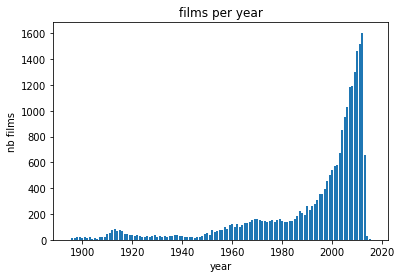

In [ ]:
import matplotlib.pyplot as plt

t = filmPerYear.collect()

tabYear = [x.production_year for x in t]
tabNb = [x.nb for x in t]

plt.bar(tabYear, tabNb)
plt.xlabel('year')
plt.ylabel('nb films')
plt.title('films per year')
plt.show()

### Requêtes sur les types de films : kind_type

In [ ]:
%sql
SELECT * 
FROM Kind_type

id,kind
1,movie
2,tv series
3,tv movie
4,video movie
5,tv mini series
6,video game
7,episode


#### Jointure entre Title et Kind_Type

In [ ]:
title.printSchema()

root
-- id: integer (nullable = true)
-- title: string (nullable = true)
-- imdb_index: string (nullable = true)
-- kind_id: integer (nullable = true)
-- production_year: integer (nullable = true)
-- imdb_id: integer (nullable = true)
-- phonetic_code: string (nullable = true)
-- episode_id: string (nullable = true)
-- season_nr: integer (nullable = true)
-- episode_nr: integer (nullable = true)
-- series_years: string (nullable = true)
-- md5sum: string (nullable = true)

In [ ]:
%sql
SELECT k.kind, t.title, t.production_year 
FROM Title t, Kind_Type k 
WHERE t.kind_id = k.id
ORDER BY t.production_year DESC

#### Nombre de films par type

In [ ]:
%sql
SELECT k.kind, count(*) as nb
FROM Title t, Kind_Type k 
WHERE t.kind_id = k.id
GROUP BY k.kind
ORDER BY count(*) DESC

kind,nb
episode,15274
movie,6602
video movie,1175
tv movie,979
tv series,925
video game,129


### Requêtes sur les rôles : cast_info

#### Une personne a un ou plusieurs roles dans un film

In [ ]:
cast_info.printSchema()

root
-- id: integer (nullable = true)
-- person_id: integer (nullable = true)
-- movie_id: integer (nullable = true)
-- person_role_id: integer (nullable = true)
-- note: string (nullable = true)
-- nr_order: integer (nullable = true)
-- role_id: integer (nullable = true)

In [ ]:
cast_info.count()

360035

#### Nombre de roles par personne

In [ ]:
res2 = spark.sql("""

select person_id, count(*) as nbRoles
from Cast_Info
group by person_id
order by nbRoles desc

""")
res2.persist()
res2.show(5)

+---------+-------+
person_id|nbRoles|
+---------+-------+
 175411| 120|
 95397| 118|
 515315| 108|
 1495180| 105|
 677696| 90|
+---------+-------+
only showing top 5 rows

descrire la distribution de l'attribut nbRoles

In [ ]:
d = res2.describe('nbRoles')
d.show()

+-------+------------------+
summary| nbRoles|
+-------+------------------+
 count| 214749|
 mean|1.6765386567574239|
 stddev|1.9565121381308854|
 min| 1|
 max| 120|
+-------+------------------+

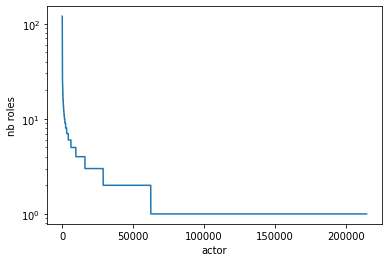

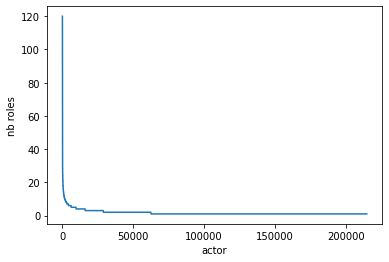

In [ ]:
#t2 = res2.sample(0.01).collect()
t2 = res2.collect()

tabNb = [x.nbRoles for x in t2]

plt.yscale('log')
plt.plot(tabNb) 
plt.xlabel('actor')
plt.ylabel('nb roles')

#plt.hist(tabNb)
plt.show()

plt.yscale('linear')
plt.plot(tabNb) 
plt.xlabel('actor')
plt.ylabel('nb roles')

plt.show()

#### Le nombre de rôles par type de film depuis 2010

In [ ]:
res3 = spark.sql("""
SELECT g.kind, count(*) as nb_roles
FROM Cast_Info c, Title f, Kind_type g
WHERE c.movie_id = f.id AND f.kind_id = g.id
AND f.production_year > 2010
GROUP BY g.kind
ORDER BY nb_roles desc
""")
res3.show(5)

+-----------+--------+
 kind|nb_roles|
+-----------+--------+
 episode| 36527|
 movie| 15897|
 tv movie| 1842|
video movie| 1421|
 tv series| 943|
+-----------+--------+
only showing top 5 rows

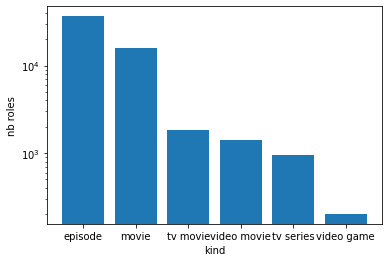

In [ ]:
t3 = res3.collect()

tabNb = [x.nb_roles for x in t3]
tabKind = [x.kind for x in t3]

plt.yscale('log')
plt.bar(tabKind,tabNb) 
plt.xlabel('kind')
plt.ylabel('nb roles')

#plt.hist(tabNb)

plt.show()

## Autres traitements

### Extraction de la date de sortie _release_dates_

In [ ]:
%sql
create or replace temp view TitleDetail as
select t.id, t.title, t.production_year, k.kind, it.info as property, m.info as value
from Title t, Movie_Info m, Info_type it, Kind_Type k
where t.id = m.movie_id 
and m.info_type_id = it.id
and t.kind_id = k.id
;

select * 
from TitleDetail t
order by  t.production_year desc, t.title
limit 100;

Mémoriser le résultat de TitleDetail pour éviter de le calculer plusieurs fois

In [ ]:
%sql
cache table TitleDetail

Une oeuvre peut avoir les propriétés suivantes

#### Informations détaillées sur toutes les propriétés d'une personne

In [ ]:
%sql
create or replace temp view NameDetail as
select n.id, n.name, n.gender, i.info as property, p.info as value
from Name n, Person_Info p, Info_type i
where n.id = p.person_id
and p.info_type_id = i.id
;
 
select * 
from NameDetail n
where n.name like 'Smi%'
order by n.name, n.property
limit 100;

Mémoriser le résultat de NameDetail pour éviter de le calculer plusieurs fois

In [ ]:
%sql
cache table NameDetail;

Une personne peut avoir les propriétés suivantes

#### Structurer la date de sortie d'un film
sélection des infos sur la date de sortie

In [ ]:
%sql
create or replace temp view Release_Date as
select t1.id, t1.title, t1.value as release_date
from TitleDetail t1
where t1.property = "release dates";

select * from Release_Date limit 3;

id,title,release_date
13,Intro: By My Side,Italy:29 March 2012
434,Brand in Mokum,Netherlands:7 January 2013
1680,A Tiny Problem in the Kitchen,USA:11 May 2011


découper la chaine _release_date_  pour séparer  le pays et la date

In [ ]:
%sql
create or replace temp view SplitDate as 
select r.id, r.title, split(release_date, ':') as splitDate
from Release_Date r;

select *  from SplitDate s limit 3;

id,title,splitDate
13,Intro: By My Side,"List(Italy, 29 March 2012)"
434,Brand in Mokum,"List(Netherlands, 7 January 2013)"
1680,A Tiny Problem in the Kitchen,"List(USA, 11 May 2011)"


In [ ]:
%sql
create or replace temp view CountryDMY as 
select s.id, s.title, element_at(s.splitDate, 1) as country, split(element_at(s.splitDate, 2),' ') as DMY
from SplitDate s
;

select * from  CountryDMY limit 3;

id,title,country,DMY
13,Intro: By My Side,Italy,"List(29, March, 2012)"
434,Brand in Mokum,Netherlands,"List(7, January, 2013)"
1680,A Tiny Problem in the Kitchen,USA,"List(11, May, 2011)"


extraire les attributs : day, month, year

In [ ]:
%sql
-- à compléter
create or replace temp view ExtractDate as
select c.id, c.title, c.country, element_at(c.DMY, 1) as Day, element_at(c.DMY, 2) as Month, element_at(c.DMY, 3) as Year
from CountryDMY c
;

select * from ExtractDate limit 3;

id,title,country,Day,Month,Year
13,Intro: By My Side,Italy,29,March,2012
434,Brand in Mokum,Netherlands,7,January,2013
1680,A Tiny Problem in the Kitchen,USA,11,May,2011


### Diverses requêtes

#### Exemple de jointure naturelle vs. jointure externe

Jointure naturelle: Seulement les films possédant la propriété _color info_

In [ ]:
%sql
-- on sait que la référence info_type_id vaut 2 pour 'color info' dans Movie_Info

select t.id, t.title, m.info as color_info
from Title t, Movie_Info m
where t.id = m.movie_id 
and m.info_type_id = 2
order by id
limit 5;

id,title,color_info
54,"Easy, Writer",Color
160,"Mystic, CT",Color
296,Camp Dance,Color
358,The Great Un-Escape,Color
614,Dream Weaver,Color


#### Questions diverses
Quels sont tous les noms d'attributs en rapport avec une date ?

In [ ]:
%sql
select *
from Info_type t
where t.info like '%date%'

id,info
16,release dates
21,birth date
23,death date
50,LD release date
102,production dates
104,filming dates


Quelle est la syntaxe de la fonction **if** dans la clause select ?

In [ ]:
%sql
select n.name, n.gender, if(gender='m', 'Mr' , if(gender='f', 'Mme', 'Inconnue' )) as civilite
from Name n
where name like '%isa';

# QUESTIONS

## Restructuration depuis la table NameDetail

Définir ces relations apportant des informations structurées sur les personnes : 
 - une table Nickname assez simple qui redéfini la propriété nick names en un nouvel attribut de personne
 - une table Birth_actor qui inclut la date, le lieu et le nom de naissance des personnes
 - une table Death avec le lieu et la cause du décès des personnes
 - une table SplitMagCover avec le nom du magazine dans lequel une personne a fait la couverture, le pays et la date de ladite couverture
 - une table Heights qui recense la taille des personnes de manière exploitable, en les reconvertissant en tailles en cm, alors que les entrées de la base sont très diverses (en plusieurs unités également)

Regardons d'abord la table NameDetail

In [ ]:
%sql
select *
from NameDetail;

Commençons par passer en revue les différentes propriétés des acteurs.
Afficher les valeurs distinctes de l'apptribut property

In [ ]:
%sql
-- COMPLETER : 
select distinct property
from NameDetail;

property
where now
nick names
interviews
birth date
salary history
height
magazine cover photo
birth name
mini biography
other works


#### Nicknames
Penser à transformer la valeur nick names en nouvel attribut, et à supprimer quelques caractères superflus

définir Nicknames(id, Name, Gender, Nickname)

In [ ]:
%sql 
create or replace temp view Nicknames as
select id, name, gender, trim(regexp_replace(value, '[\\"\\.]*', '' )) as Nickname
from NameDetail
where property = 'nick names'
;

select *
from Nicknames
order by Nickname;

#### Birth_Actor 
avec nom, date et lieu de naissance

Birth_Actor (id, name, birth date, birth_name, birth_place, day, month, year)

In [ ]:
%sql

create or replace temp view Birth_Actor as
select n.id, n.name, d.value as Birth_date,
n.Birth_name as Birth_Name, 
note.Birth_place as Birth_Place, 
element_at(d.Birth_date, 1) as Day_of_birth, 
element_at(d.Birth_date, 2) as Month_of_birth, 
element_at(d.Birth_date, 3) as Year_of_birth 

from ( select id, name, value as Birth_name
       from NameDetail
       where property = 'birth name'
     ) as n,
     
     ( select id, value, split(value,' ') as Birth_date
       from NameDetail 
       where property = 'birth date'
     ) as d,
     
     ( select id, value as Birth_place
       from NameDetail
       where property = 'birth notes'
     ) as note
     
where n.id = d.id
  and n.id = note.id
;

select *
from Birth_Actor;

#### Death
La table Death avec lieu et cause de la mort en séparant le champ *death note* 

Death(id, name, location_of_death, cause_of_death)

In [ ]:
%sql
create or replace temp view Death as
select id, name, 
       regexp_extract(value, '([^\\(]*)(\\((.+)\\))*', 1) as Location_of_death,
       regexp_extract(value, '([^\\(]*)(\\((.+)\\))*', 3) as Cause_of_death
        
from NameDetail
where property = 'death notes'
;

--.....


select *
from Death;

#### SplitMagCover 
Definir tout d'abord *Magazine cover photo*

Magazine_cover_photo(id, name, Cover_from_Magazine, Country, Date)

In [ ]:
%sql 
create or replace temp view Magazine_Cover_Photo as
select id, name,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 1) as Cover_from_Magazine,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 2) as Country,
regexp_extract(value, '\\"(.+)\\" \\(([^\\)]+)\\), ([^,]*)', 3) as Date

from NameDetail
where property = 'magazine cover photo'
;

select *
from Magazine_Cover_Photo

puis definir la relation SplitMagCover avec nom du magazine, pays et date de couverture

SplitMagCover(id, name, cover_from_magazine, date)

In [ ]:
%sql 
create or replace temp view SplitMagCover as 
select Cover_from_Magazine as Cover_from_Magazine, 
Country as Country, Date as Date
from Magazine_cover_photo
;

select *
from SplitMagCover

#### Height
avec la taille des acteurs, la difficulté réside dans le reformatage/conversion des tailles en cm, feet et inches, 

Height(id, name, height_in_cm)

In [ ]:
%sql 
create or replace temp view Height as 
select id, name, 
if (locate('cm', value)>0, regexp_extract(value, "(.+) cm", 1),
if (locate('"', value)=0 , cast(regexp_extract(value, "(.+)'", 1) as int)*30.48,
if (locate('1/2', value)>0, (cast(regexp_extract(value, "(.+)' ([0-9]+)", 1) as int)+ (cast(regexp_extract(value, "(.+)' ([0-9]+)", 2) as int)+0.5)/12)*30.48, 
(cast(regexp_extract(value, "(.+)' ([0-9]+)", 1) as int)+ cast(regexp_extract(value, "(.+)' ([0-9]+)", 2) as int)/12)*30.48))) as height_in_cm
from NameDetail
where property = 'height'
;

select id, name, int(height_in_cm) as height_in_cm
from Height
order by height_in_cm desc
limit 10

id,name,height_in_cm
111308,"Bear, Bart the",289
413534,"Douglass, Jack",273
576560,"Gonzáles, Jorge",228
1016803,"McGrory, Matthew",228
1711328,"Yao, Ming",227
1314391,"Robbins, Garry",226
154065,"Bloom, John",223
1369034,"Sampson, Ralph",223
627793,"Hamilton, Mark",220
2748,"Abdul-Jabbar, Kareem",218


In [ ]:
%sql -- confirmation que la base de données a une valeur bizarre pour Jack Douglass :
select id, name, value
from NameDetail
where property = 'height' and id = 413534

id,name,value
413534,"Douglass, Jack","8' 11 1/2"""


##  Restructuration depuis la table TitleDetail

Définir des relations sur les oeuvres : 
 - une table Anecdote assez simple qui redéfini la propriété trivia en un nouvel attribut d'une oeuvre
 - une table length avec la durée des oeuvres et un rapide histogramme représentant le gros des données
 - une table title_with_color qui défini le caractère en couleur ou noir et blanc d'une oeuvre
 - une table movie_rentals avec la valeur et la somme et la devise monétaire correspondante
 - une table title_filming_date avec les dates de début et de fin de tournage des oeuvres, structurées en jours, mois et années

In [ ]:
%sql -- la table TitleDetail
select *
from TitleDetail

#### Anecdotes

Anecdote(id, title, fun_fact)

In [ ]:
%sql -- Une première table avec un fun fact
create or replace temp view Anecdote as
select id, title, value as fun_fact
from TitleDetail
where property = 'trivia'
;

select * from Anecdote;

#### Durée d'un DVD

DVDLength(id, title, length)

In [ ]:
%sql 
Create or replace temp view DVDlengths as
select distinct id, title, cast(value as int) as length
from titledetail
where property = 'LD length'
order by length desc
;

select *
from DVDlengths

Distribution des durées: combien de films dont la durée est inférieur à 50' minutes, supérieure à 150' ?

+-------+------+
 id|length|
+-------+------+
1762044| 570|
2243428| 320|
1655163| 300|
2219245| 130|
1714929| 128|
+-------+------+
only showing top 5 rows

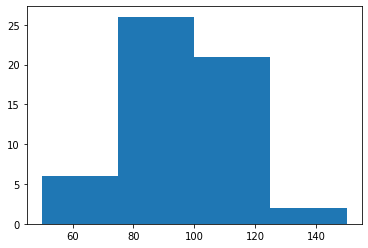

In [ ]:
res3 = spark.sql("""
SELECT id, cast(value as int) as length
FROM titledetail
WHERE property = 'LD length'
ORDER by length desc
""")
res3.show(5)

t = res3.collect()
tab = [x.length for x in t]
plt.hist(tab, bins = [50,75,100,125,150])
plt.show()

#### Titres de films dont on connait l'indication de couleur ou de N&B

In [ ]:
%sql 
create or replace temp view title_with_color as
select id, title, value as Color_or_BW
from TitleDetail
where property = 'color info'
;

select * from title_with_color;

#### Movie Rentals

Movie_rentals(id, title, rental_value, currency, country)

In [ ]:
%sql
create or replace temp view Movie_rentals as
select id, title, 
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 2) as rental_value,
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 1) as currency,
regexp_extract(value, '(.)([0-9,]+)( \\((.+)\\))*', 4) as country
from TitleDetail
where property = 'rentals'
;

select *
from Movie_rentals;

id,title,rental_value,currency,country
1666737,Adventure,"4,236,000",$,USA
1714929,Basic Instinct,"53,000,000",$,USA
1714929,Basic Instinct,"8,500,000",£,UK
1763216,Catch-22,"12,250,000",$,USA
1776735,Circle of Iron,"1,000,000",$,USA
1875462,European Vacation,"25,600,000",$,USA
2351874,The Bowery,"1,494,294",$,USA
2388912,The Love Bug,"23,150,000",$,USA
2082136,Looking for Mr. Goodbar,"16,900,000",$,
1833314,Diner,"4,000,000",$,USA


####  date de début et fin de tournage 

Title_filming_date(id, title, start_date, end_date)

In [ ]:
%sql -- Cinquième table de
create or replace temp view title_filming_date as
select id, title,
trim(regexp_extract(value, '([^-]*)', 1)) as Start_date,
trim(regexp_extract(value, '[^-]*-(.*)', 1)) as Ending_date
from titleDetail
where property = 'filming dates'
;

select *
from title_filming_date;

#### réorganiser ces dates par jour, mois et année de début et fin de tournage

Title_filming_date (id, title, start_day, start_month, start_year, end_day, end_month, end_year)

In [ ]:
%sql 
--create or replace temp view title_filming_date as
select id, title, 
regexp_extract(Start_date, '^([0-9]{1,2})[^0-9]', 1) as Starting_day,
regexp_extract(Start_date, '[^a-zA-Z]*([a-zA-Z]*) [0-9]', 1) as Starting_Month,
regexp_extract(Start_date, '[^a-zA-Z]*[a-zA-Z ]*([0-9]{4})', 1) as Starting_Year,
regexp_extract(Ending_date, '^([0-9]{1,2})[^0-9]', 1) as Ending_day,
regexp_extract(Ending_date, '[^a-zA-Z]*([a-zA-Z]*) [0-9]', 1) as Ending_Month,
regexp_extract(Ending_date, '[^a-zA-Z]*[a-zA-Z ]*([0-9]{4})', 1) as Ending_Year

from title_filming_date
;

--select * from title_filming_date;

#### Role H/F
nombre d'H et de F par profession, 
pourcentage H F par profession

RoleHF(role, nbH, nbF, Hpct, Fpct)